In [1]:
#!apt-key adv --fetch-keys http://developer.download.nvidia.com/compute/cuda/repos/ubuntu1604/x86_64/3bf863cc.pub
#!apt-get update && apt install -y git


In [1]:
import datetime
#!pip install git+https://github.com/matterport/Mask_RCNN.git --upgrade
!pip install git+https://github.com/mdrokz/Mask-RCNN-TF2.7.0-keras2.7.0.git --upgrade

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/mdrokz/Mask-RCNN-TF2.7.0-keras2.7.0.git to /tmp/pip-req-build-sdfgqxi8
  Running command git clone --filter=blob:none -q https://github.com/mdrokz/Mask-RCNN-TF2.7.0-keras2.7.0.git /tmp/pip-req-build-sdfgqxi8
  Resolved https://github.com/mdrokz/Mask-RCNN-TF2.7.0-keras2.7.0.git to commit 87246652e054b79781a155ab151ecad0b1634e48
  Preparing metadata (setup.py) ... done
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


# Dependencies

In [13]:
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"]  = "python"

# Import
In order to train, we would need GPU power

In [1]:
import tensorflow as tf
import keras

print(tf.__version__)
print(keras.__version__)
import pathlib
from numpy import asarray
import mrcnn.utils
import mrcnn.config
import mrcnn.model
from mrcnn import visualize
from datasets import load_dataset
import numpy as np
from mrcnn import utils
import imgaug
import warnings

2.7.0
2.6.0


2023-03-24 14:39:11.164626: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38052 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 3g.40gb, pci bus id: 0000:82:00.0, compute capability: 8.0


In [2]:
# Check if GPU is available
print("Num GPUs Available: ", tf.config.list_physical_devices("GPU"))

from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())


Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1942050026387701476
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 39901331456
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 1180202006654335441
physical_device_desc: "device: 0, name: NVIDIA A100 80GB PCIe MIG 3g.40gb, pci bus id: 0000:82:00.0, compute capability: 8.0"
xla_global_id: 416903419
]


2023-03-24 14:39:12.376893: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 38052 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 3g.40gb, pci bus id: 0000:82:00.0, compute capability: 8.0


In [3]:
WEIGHTS_PATH = pathlib.Path("weights")
WEIGHTS_PATH.mkdir(exist_ok=True)

WEIGHTS_CHECKPOINT_PATH = WEIGHTS_PATH.joinpath("checkpoints")
WEIGHTS_CHECKPOINT_PATH.mkdir(exist_ok=True)


COCO_WEIGHTS = WEIGHTS_PATH.joinpath("mask_rcnn_coco.h5")
FROG_WEIGHTS = WEIGHTS_PATH.joinpath('mask_rcnn_frog.h5')


CLASS_NAME = "frog_stomach"
CLASS_NAMES = [CLASS_NAME, "BG"]
FROG_IMAGES = "./frog_photos"
FROG_DATASET = "perara/pelophylax_lessonae"


WEIGHTS_CHECKPOINT_PATH.joinpath(CLASS_NAME).mkdir(exist_ok=True)

In [17]:
#import shutil
#shutil.rmtree(FROG_IMAGES)

# Download COCO weights if missing

In [4]:
if not COCO_WEIGHTS.exists():
    utils.download_trained_weights(str(COCO_WEIGHTS.absolute()))

# Configure dataset

In [5]:

from mrcnn.model import DataGenerator
from PIL import Image, ImageDraw


class FrogStomachDataset(mrcnn.utils.Dataset):

    def load_dataset(self, images_dir: str, dataset_dir: str=None, is_train=True):
        # Adds information (image ID, image path, and annotation file path) about each image in a dictionary.
        self.add_class("dataset", 1, CLASS_NAME)

        images_dir_path = pathlib.Path(images_dir)
        dataset_split = "train" if is_train else "validation"
        ds = load_dataset(
            FROG_DATASET,
            name="default",
            splits=[dataset_split],
            image_dir=images_dir_path,
            data_dir=dataset_dir
        )

        hmm = ds[dataset_split]
        for sample in hmm:
            image_id = sample["image_id"]
            image_path = sample["image_path"]
            annotation = sample["segmentation"]
            width, height = Image.open(image_path).size
            category_id = sample["category_id"]

            self.add_image('dataset', image_id=image_id, path=image_path, annotation=annotation, width=width, height=height, category_id=category_id)

    # Loads the binary masks for an image.
    def load_mask(self, image_id):

        image_info = self.image_info[image_id]
        annotations = image_info['annotation']
        width = image_info["width"]
        height = image_info["height"]
        category_id = image_info["category_id"]
        instance_masks = []
        class_ids = []


        mask = Image.new('1', (width, height))
        mask_draw = ImageDraw.ImageDraw(mask, '1')
        for segmentation in annotations:
            try:
                mask_draw.polygon(segmentation, fill=1)
            except:
                pass
            bool_array = np.array(mask) > 0
            instance_masks.append(bool_array)
            class_ids.append(category_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)

        return mask.astype("bool"), asarray(class_ids, dtype='int32')

# Load Training and Validation Dataset

In [6]:
train_dataset = FrogStomachDataset()
train_dataset.load_dataset(
    images_dir=str(FROG_IMAGES),
    dataset_dir=str(FROG_DATASET),
    is_train=True
)
train_dataset.prepare()

Found cached dataset pelophylax_lessonae (/home/nicolaiep/.cache/huggingface/datasets/perara___pelophylax_lessonae/default-5e6aef655dc4caf4/0.0.0/806e2c07d39e82f6c75ce9b1a3e1bcb48cccd7c9870701f20dcc227f4070d66f)


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
# Train
train_dataset = FrogStomachDataset()
train_dataset.load_dataset(
    images_dir=str(FROG_IMAGES),
    dataset_dir=str(FROG_DATASET),
    is_train=True
)
train_dataset.prepare()

val_dataset = FrogStomachDataset()
val_dataset.load_dataset(
    images_dir=str(FROG_IMAGES),
    dataset_dir=str(FROG_DATASET),
    is_train=False
)
val_dataset.prepare()

Found cached dataset pelophylax_lessonae (/home/nicolaiep/.cache/huggingface/datasets/perara___pelophylax_lessonae/default-5e6aef655dc4caf4/0.0.0/806e2c07d39e82f6c75ce9b1a3e1bcb48cccd7c9870701f20dcc227f4070d66f)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset pelophylax_lessonae (/home/nicolaiep/.cache/huggingface/datasets/perara___pelophylax_lessonae/default-3294884add618a56/0.0.0/806e2c07d39e82f6c75ce9b1a3e1bcb48cccd7c9870701f20dcc227f4070d66f)


  0%|          | 0/1 [00:00<?, ?it/s]

# Visualize samples from Validation Set

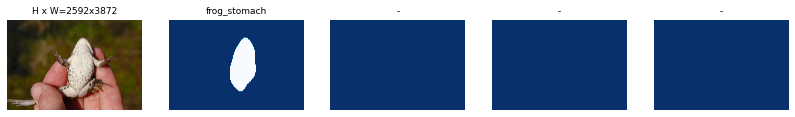

In [7]:
image_ids = np.random.choice(val_dataset.image_ids, 1)
for image_id in image_ids:
    image = val_dataset.load_image(image_id)
    mask, class_ids = val_dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, val_dataset.class_names)

# Setup Mask R-CNN - Training Model

In [8]:
class FrogStomachConfig(mrcnn.config.Config):
    NAME = CLASS_NAME
    GPU_COUNT = 1
    NUM_CLASSES =  1 + 1


    DETECTION_MIN_CONFIDENCE = 0.9

    IMAGES_PER_GPU = 32
    STEPS_PER_EPOCH = 100
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128
EPOCHS = 100


# Model Configuration
frog_config = FrogStomachConfig()

def setup_model():

    # Build the Mask R-CNN Model Architecture
    train_model = mrcnn.model.MaskRCNN(mode='training',
                                 model_dir=str(WEIGHTS_PATH.absolute()),
                                 config=frog_config)

    """train_model.keras_model.add_metric(
        tf.keras.metrics.MeanIoU(name="mean_io_u_1",dtype=tf.float32,num_classes=2), name="metric_io_u"
    )"""

    #last_model = train_model.find_last()
    #train_model.load_weights(filepath=last_model, by_name=True , exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

    train_model.load_weights(filepath=str(COCO_WEIGHTS.absolute()),
                             by_name=True,
                             exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
    return train_model


# Setup Mask R-CNN - Inference Model

In [10]:
class InferenceConfig(FrogStomachConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    USE_MINI_MASK = False

inference_config = InferenceConfig()

# Recreate the model in inference mode
inference_model = mrcnn.model.MaskRCNN(mode="inference",
                             config=inference_config,
                             model_dir=str(WEIGHTS_PATH.absolute()))

Instructions for updating:
Use fn_output_signature instead


# Train using Transfer Learning

In [9]:
"""
from callbacks import MeanAveragePrecisionCallback

mean_average_precision_callback = MeanAveragePrecisionCallback(
    train_model,
    inference_model,
    val_dataset,
    calculate_map_at_every_X_epoch=1,
    verbose=1
)
"""

train_model = setup_model()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    train_model.train(train_dataset=train_dataset,
                val_dataset=val_dataset,
                learning_rate=frog_config.LEARNING_RATE,
                custom_callbacks= [],
                epochs=EPOCHS,
                layers='heads')
    """augmentation = imgaug.augmenters.Sometimes(0.5, [
        imgaug.augmenters.Fliplr(0.5),
        imgaug.augmenters.GaussianBlur(sigma=(0.0, 5.0))
    ]),"""

    train_model.keras_model.save_weights(str(FROG_WEIGHTS.absolute()))



Starting at epoch 0. LR=0.001

Checkpoint Path: /home/nicolaiep/weights/frog_stomach20230324T1440/mask_rcnn_frog_stomach_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_d

2023-03-24 14:42:06.808376: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302
2023-03-24 14:42:08.325340: I tensorflow/stream_executor/cuda/cuda_blas.cc:1792] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-24 14:42:10.769562: W tensorflow/core/kernels/gpu_utils.cc:49] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


  1/100 [..............................] - ETA: 2:20:03 - batch: 0.0000e+00 - size: 32.0000 - loss: 9.7984 - rpn_class_loss: 0.1037 - rpn_bbox_loss: 6.3629 - mrcnn_class_loss: 1.7154 - mrcnn_bbox_loss: 0.8171 - mrcnn_mask_loss: 0.7993

2023-03-24 14:43:08.196160: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2023-03-24 14:43:08.196220: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2023-03-24 14:43:08.196296: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1630] Profiler found 1 GPUs
2023-03-24 14:43:47.683310: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-03-24 14:43:47.686808: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1765] CUPTI activity buffer flushed
2023-03-24 14:43:47.885713: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:526]  GpuTracer has collected 16138 callback api events and 14660 activity events. 
2023-03-24 14:43:48.285103: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.
2023-03-24 14:43:48.823518: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /home/nicolaiep/weights/frog_stomach

  2/100 [..............................] - ETA: 1:32:19 - batch: 0.5000 - size: 32.0000 - loss: 9.0112 - rpn_class_loss: 0.1142 - rpn_bbox_loss: 6.1019 - mrcnn_class_loss: 1.1251 - mrcnn_bbox_loss: 0.8824 - mrcnn_mask_loss: 0.7876    

2023-03-24 14:43:49.587186: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /home/nicolaiep/weights/frog_stomach20230324T1440/plugins/profile/2023_03_24_14_43_48

2023-03-24 14:43:49.602317: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to /home/nicolaiep/weights/frog_stomach20230324T1440/plugins/profile/2023_03_24_14_43_48/jupyter-nicolaiep.memory_profile.json.gz
2023-03-24 14:43:49.621281: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: /home/nicolaiep/weights/frog_stomach20230324T1440/plugins/profile/2023_03_24_14_43_48
Dumped tool data for xplane.pb to /home/nicolaiep/weights/frog_stomach20230324T1440/plugins/profile/2023_03_24_14_43_48/jupyter-nicolaiep.xplane.pb
Dumped tool data for overview_page.pb to /home/nicolaiep/weights/frog_stomach20230324T1440/plugins/profile/2023_03_24_14_43_48/jupyter-nicolaiep.overview_page.pb
Dumped tool data for input_pipe

100/100 [==============================] - 3793s 37s/step - batch: 49.5000 - size: 32.0000 - loss: 0.6917 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.2961 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.1772 - mrcnn_mask_loss: 0.1732 - val_loss: 0.3899 - val_rpn_class_loss: 0.0095 - val_rpn_bbox_loss: 0.1902 - val_mrcnn_class_loss: 0.0069 - val_mrcnn_bbox_loss: 0.0690 - val_mrcnn_mask_loss: 0.1143
Epoch 2/100
100/100 [==============================] - 3557s 36s/step - batch: 49.5000 - size: 32.0000 - loss: 0.2482 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0804 - mrcnn_class_loss: 0.0055 - mrcnn_bbox_loss: 0.0505 - mrcnn_mask_loss: 0.1081 - val_loss: 0.3540 - val_rpn_class_loss: 0.0099 - val_rpn_bbox_loss: 0.1752 - val_mrcnn_class_loss: 0.0064 - val_mrcnn_bbox_loss: 0.0582 - val_mrcnn_mask_loss: 0.1044
Epoch 3/100
 35/100 [=========>....................] - ETA: 36:22 - batch: 17.0000 - size: 32.0000 - loss: 0.2440 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0888 - mrcnn_class_loss: 0.0

KeyboardInterrupt: 

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also
# pass a regular expression to select which layers to
# train by name pattern.
train_model.train(train_dataset, val_dataset,
            learning_rate=frog_config.LEARNING_RATE / 10,
            epochs=int(EPOCHS / 2),
            layers="all")


In [15]:
inference_model_path = inference_model.find_last()
#p = "weights/frog_stomach20230305T2047/mask_rcnn_frog_stomach_0063.h5"
print("Loading weights from ", inference_model_path)
#print("Loading weights from ", p)

inference_model.load_weights(p, by_name=True)

Loading weights from  /home/nicolaiep/weights/frog_stomach20230320T1255/mask_rcnn_frog_stomach_0100.h5
Re-starting from epoch 63


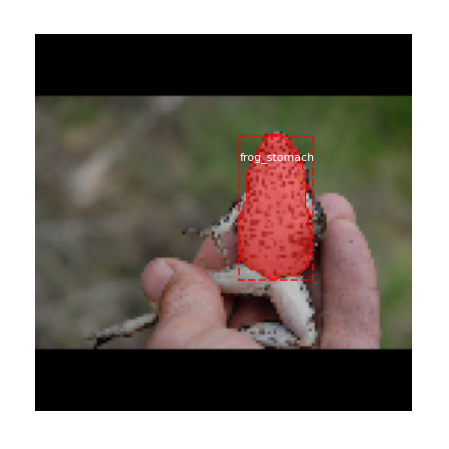

In [16]:
import random
# Test on a random image
image_id = random.choice(val_dataset.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    mrcnn.model.load_image_gt(val_dataset, inference_config, image_id)



visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id,
                            train_dataset.class_names, figsize=(8, 8))


(128, 128, 3)
image ID: dataset.523 (523) 
Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  147.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -2.85070  max:    3.34676  float32


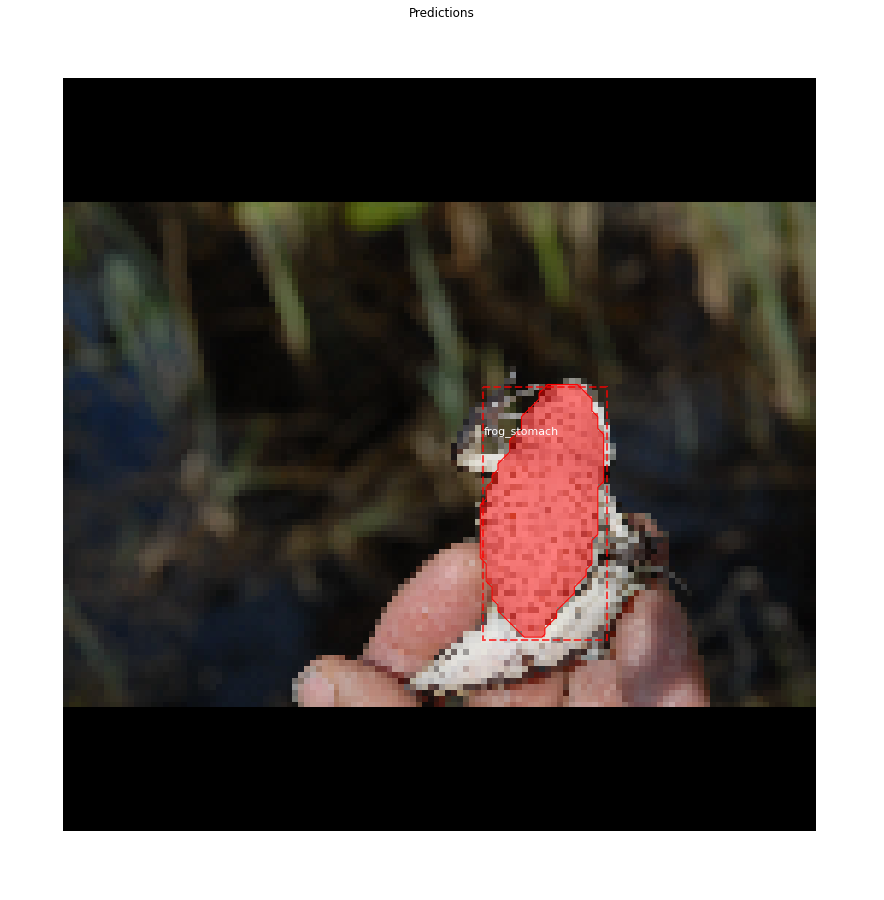

gt_class_id              shape: (3,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (3, 4)                min:   53.00000  max:   95.00000  int32
gt_mask                  shape: (128, 128, 3)         min:    0.00000  max:    1.00000  bool


In [17]:
from mrcnn.model import log
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

dataset = train_dataset
config = inference_config

image_id = random.choice(dataset.image_ids)

image, image_meta, gt_class_id, gt_bbox, gt_mask = mrcnn.model.load_image_gt(dataset, config, image_id)

print(image.shape)

info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id,
                                       dataset.image_reference(image_id)))

# Run object detection
results = inference_model.detect([image], verbose=1)

# Display results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'], title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

In [18]:

dataset = train_dataset

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))


Images: 757
Classes: ['BG', 'frog_stomach']


Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  235.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  130.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -2.85070  max:    3.34676  float32


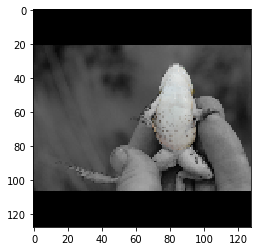

In [19]:
import skimage.io
import skimage.color
from matplotlib import pyplot as plt

def color_splash(image, mask):
    """Apply color splash effect.
    image: RGB image [height, width, 3]
    mask: instance segmentation mask [height, width, instance count]
    Returns result image.
    """
    # Make a grayscale copy of the image. The grayscale copy still
    # has 3 RGB channels, though.
    gray = skimage.color.gray2rgb(skimage.color.rgb2gray(image)) * 255
    # We're treating all instances as one, so collapse the mask into one layer
    mask = (np.sum(mask, -1, keepdims=True) >= 1)
    # Copy color pixels from the original color image where mask is set
    if mask.shape[0] > 0:
        splash = np.where(mask, image, gray).astype(np.uint8)
    else:
        splash = gray
    return splash

def detect_and_color_splash(model, image=None):


    #print("Running on {}".format(args.image))
    # Read image
    #image = skimage.io.imread(args.image)
    # Detect objects
    r = model.detect([image], verbose=1)[0]
    # Color splash
    splash = color_splash(image, r['masks'])
    # Save output
    #file_name = "splash_{:%Y%m%dT%H%M%S}.png".format(datetime.datetime.now())
    #skimage.io.imsave(file_name, splash)
    return splash

image_ids = np.random.choice(val_dataset.image_ids, 1)
for image_id in image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask = mrcnn.model.load_image_gt(val_dataset, config, image_id)

    splash = detect_and_color_splash(inference_model, image)


    plt.imshow(splash, interpolation='nearest')
    plt.show()

In [23]:
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.utils import compute_ap, compute_recall
from numpy import expand_dims
from mrcnn import utils

from statistics import mean

def evaluate_model(dataset, model, cfg):
    APs = list()
    ARs = list()
    F1_scores = list()
    for image_id in dataset.image_ids:
        #image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id)
        scaled_image = mold_image(image, cfg)
        sample = expand_dims(scaled_image, 0)
        yhat = model.detect(sample, verbose=0)
        r = yhat[0]
        AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        AR, positive_ids = compute_recall(r["rois"], gt_bbox, iou=0.2)
        ARs.append(AR)
        F1_scores.append((2* (mean(precisions) * mean(recalls)))/(mean(precisions) + mean(recalls)))#Method 1
        APs.append(AP)
    mAP = mean(APs)
    mAR = mean(ARs)
    return mAP, mAR, F1_scores


mAP, mAR, F1_score = evaluate_model(val_dataset, inference_model, inference_config)
print("mAP: %.3f" % mAP)
print("mAR: %.3f" % mAR)
print("first way calculate f1-score: ", F1_score)
F1_score_2 = (2 * mAP * mAR)/(mAP + mAR)#Method 2
print('second way calculate f1-score_2: ', F1_score_2)

mAP: 0.965
mAR: 0.965
first way calculate f1-score:  [0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.5714285714285715, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666